<a href="https://colab.research.google.com/github/muhammadghazyy/mask_detector/blob/main/model_building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.applications import EfficientNetB7

from google.colab import files

In [4]:
print('GPU available' if tf.config.list_physical_devices('GPU') else 'GPU is not available')

GPU available


##Kaggle Errands
https://www.kaggle.com/ashishjangra27/face-mask-12k-images-dataset

In [5]:
#upload kaggle.json
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"muhammadghazy","key":"95167f954e059f51836df3fffe7c492a"}'}

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset

 95% 314M/330M [00:09<00:00, 20.6MB/s]
100% 330M/330M [00:09<00:00, 36.3MB/s]


In [ ]:
!unzip face-mask-12k-images-dataset.zip

##Initial Parameters

In [38]:
input_shape = (120,120,3)
batch_size = 32
epochs = 30
learn_rate = 0.001
adam = tf.keras.optimizers.Adam(learning_rate=learn_rate, epsilon=False , amsgrad=False)

## Initiating Training and Validation Sets


In [28]:
train_dir = '/content/Face Mask Dataset/Train'
test_dir = '/content/Face Mask Dataset/Test'
val_dir = '/content/Face Mask Dataset/Validation'

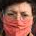

In [33]:
tf.keras.preprocessing.image.load_img(test_dir+'/WithMask/1163.png')

In [36]:
datagen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.15,
    height_shift_range = 0.15,
    shear_range = 0.15,
    zoom_range = 0.2,
    brightness_range = [0.4,1.4],
    horizontal_flip= True,
    vertical_flip = True,
    fill_mode='nearest'
)

datagen_val , datagen_test = ImageDataGenerator(),ImageDataGenerator()

In [39]:
train_generator = datagen.flow_from_directory(
    directory = train_dir,
    class_mode = 'sparse',
    target_size=(120,120),
    batch_size = 32,
    shuffle = True,
    interpolation = 'nearest'
)

Found 10000 images belonging to 2 classes.


In [40]:
val_generator = datagen_val.flow_from_directory(
    directory = val_dir,
    class_mode = 'sparse',
    target_size = (120,120),
    batch_size = 32,
    shuffle = True,
    interpolation = 'nearest'
)

Found 800 images belonging to 2 classes.


In [41]:
test_generator = datagen_test.flow_from_directory(
    directory = test_dir,
    class_mode = 'sparse',
    target_size = (120,120),
    batch_size = 32,
    shuffle = True,
    interpolation = 'nearest'
)

Found 992 images belonging to 2 classes.


In [43]:
labels = train_generator.class_indices
labels = dict((i,j) for i,j in labels.items())
n_classes = len(labels)
print(labels)
print(n_classes)

{'WithMask': 0, 'WithoutMask': 1}
2


##Model Building using EfficientNetB7

In [44]:
enb7 = EfficientNetB7(input_shape=input_shape , include_top=False, weights='imagenet')

258080768/258076736 [==============================] - 6s 0us/step


In [45]:
model = tf.keras.Sequential([
                             enb7,
                             tf.keras.layers.GlobalAveragePooling2D(),
                             tf.keras.layers.Dense(256,activation=tf.nn.relu),
                             tf.keras.layers.Dense(n_classes,activation=tf.nn.softmax)
])

In [46]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer=adam,metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb7 (Functional)  (None, 4, 4, 2560)        64097687  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               655616    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 64,753,817
Trainable params: 64,443,090
Non-trainable params: 310,727
_________________________________________________________________


In [47]:
step_size_train = train_generator.n // train_generator.batch_size
step_size_val = val_generator.n // val_generator.batch_size

In [51]:
history = model.fit(
    train_generator,
    validation_data = val_generator,
    epochs = 2,
    steps_per_epoch = step_size_train,
    validation_steps = step_size_val
)

Epoch 1/2
312/312 [==============================] - 353s 1s/step - loss: 0.0306 - acc: 0.9928 - val_loss: 0.0066 - val_acc: 0.9975
Epoch 2/2
312/312 [==============================] - 353s 1s/step - loss: 0.0599 - acc: 0.9848 - val_loss: 0.0074 - val_acc: 0.9987


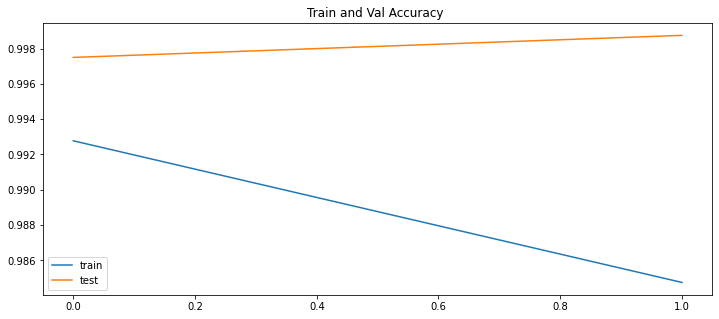

In [54]:
 plt.figure(figsize=(12,5))
plt.title('Train and Val Accuracy ')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show()

## Saving model into HDF5 File Format

In [55]:
model.save('mask_enb7.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
